In [1]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

from sklearn import (decomposition)
from  sklearn import manifold
from sklearn import cluster
import matplotlib.pyplot as plt
from MCA import PhalanxImage
import numpy as np
from pymcr.mcr import McrAR
from pymcr.constraints import ConstraintNonneg
from mpl_toolkits.mplot3d import Axes3D

In [33]:

data="/Users/morten/Documents/Raman/Elisa/20190930/scan_10x_bgcorr.ibw"
shift="/Users/morten/Documents/Raman/Elisa/20190930/scan_10x_sh_crop.txt"
image=PhalanxImage.PhalanxImage(data,shift)

endWN=image.shift[-1]
startWN=image.shift[0]

inter,wn=image.interpolatedSpectra(wnStart=startWN, wnEnd=endWN)
shape=inter.shape
flatInter=inter.reshape((shape[0]*shape[1]*shape[2],shape[3]))
minV=np.amin(flatInter)

print(shape)


if minV <0:
    flatInter += abs(minV)

def showSpectra(matrix, shift):
    spectra=np.vsplit(matrix,matrix.shape[0])
    for idx,spectrum in enumerate(spectra):
        fig, ax1 = plt.subplots()
        ax1.set_xlabel(r'$\mathregular{Raman\ Shift\ [cm^{-1}]}$')
        ax1.set_ylabel('a.u.')
        ax1.set_title("Spectrum Component {}".format(idx+1))
        ax1.plot(shift, spectrum.squeeze())
        plt.show()
    
def showImages(images):
    imageComponents = np.split(images, images.shape[3], axis=3)
    for idx,image in enumerate(imageComponents):
        plt.imshow(image.squeeze())
        plt.title("Mapping Component {}".format(idx+1))
        plt.show()

(50, 50, 1, 2419)


Lets Plot a few random spectra

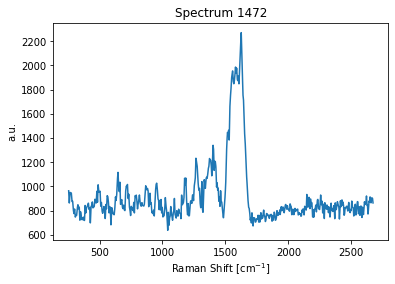

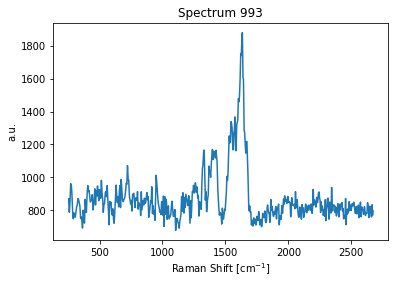

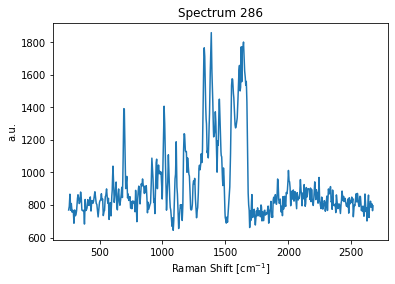

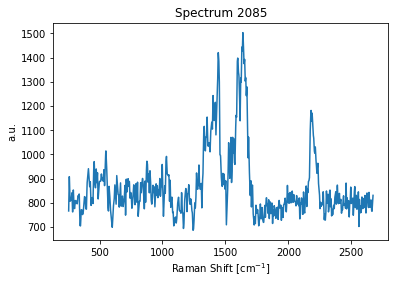

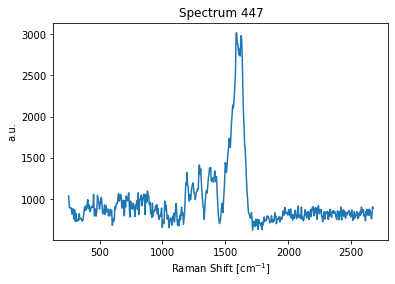

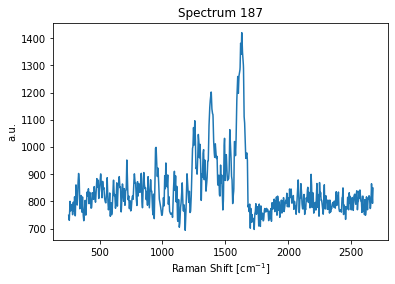

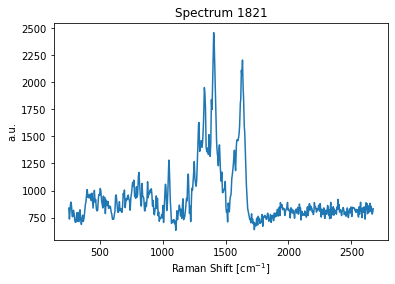

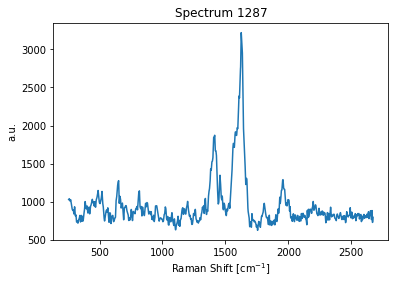

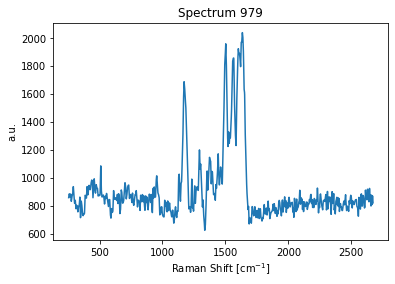

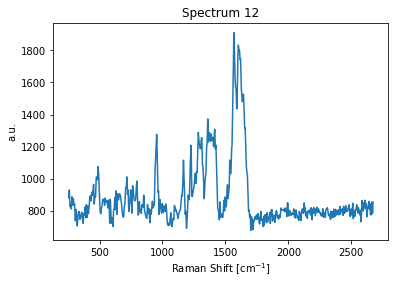

In [34]:
howMany=10
randomNumbers=np.random.randint(0,flatInter.shape[0],howMany)
xValues=np.linspace(startWN,endWN,flatInter.shape[1])
for rN in randomNumbers:
    spectrum=flatInter[rN]
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(r'$\mathregular{Raman\ Shift\ [cm^{-1}]}$')
    ax1.set_ylabel('a.u.')
    ax1.set_title("Spectrum {}".format(rN))
    ax1.plot(xValues,spectrum)
    plt.show()

Lets try Agglomerative Clustering (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
We have to decide on the number of clusters.

In [99]:
numberOfClusters=10
affinity="euclidean"
agClustering=cluster.AgglomerativeClustering(n_clusters=10, affinity=affinity)
clusters=agClustering.fit(flatInter)

In [100]:
#https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [101]:
def plotSpectra(spectralIndices, howMany, shiftWave, clusterIDX):
    randomIndices=np.random.randint(0,len(spectralIndices),howMany)
    rows=int(howMany/2)
    fig, axes = plt.subplots(rows,2, sharex="col")
    fig.suptitle("Cluster {}".format(clusterIDX))
    for idx,rN in enumerate(randomIndices):
        spectrum=flatInter[rN]
        axes.flat[idx].set_title("Spectrum {}".format(rN))
        axes.flat[idx].plot(xValues,spectrum, color=plt.cm.rainbow(clusterIDX/numberOfClusters))
        
    plt.show()

In [110]:
from matplotlib.colors import BoundaryNorm
from matplotlib.collections import LineCollection

def plotResult(labels, numberOfClusters, clusters, title, plotDendogram=True):
    
    if plot_dendrogram is True:
        plt.title(title)
        plot_dendrogram(clusters, labels=labels)
        plt.show()
    
    xValLabels=np.linspace(0,len(labels)-1,len(labels))

#     norm = BoundaryNorm(np.linspace(0,numberOfClusters-1,numberOfClusters), numberOfClusters)
    norm=BoundaryNorm([0,1,2],3)
    points = np.array([xValLabels, labels]).T.reshape(-1, 1, 2)
#     print(points)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
#     print(segments.shape)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(labels)
    lc.set_linewidth(1)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Trace #')
    ax1.set_ylabel('Label')
    
    ax1.plot(xValLabels,labels)
    ax1.add_collection(lc)
    plt.show()
    
    totalSpectra=0

    for clusterIDX in range(0,numberOfClusters):
        indices=np.where(clusters.labels_ == clusterIDX)[0]
        print("Cluster {} has {} members".format(clusterIDX,len(indices)))
        totalSpectra+=len(indices)
        plotSpectra(indices,4,xValues, clusterIDX)
    
    print("{} spectra accounted for".format(totalSpectra))



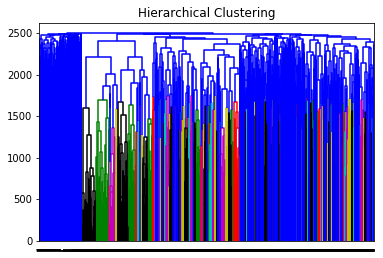

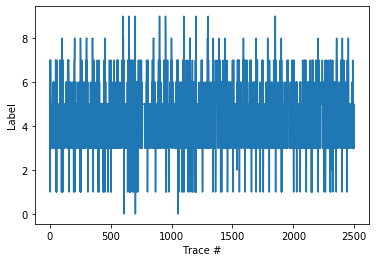

Cluster 0 has 3 members


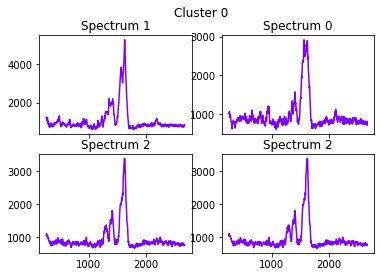

Cluster 1 has 90 members


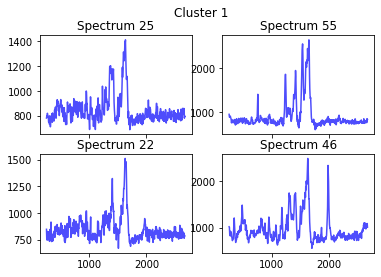

Cluster 2 has 3 members


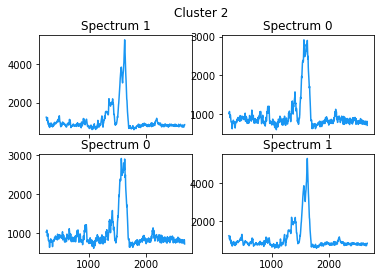

Cluster 3 has 628 members


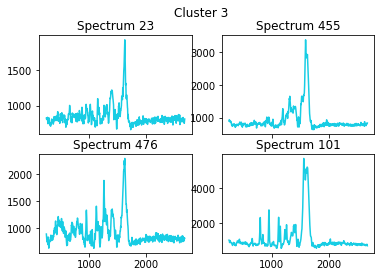

Cluster 4 has 2 members


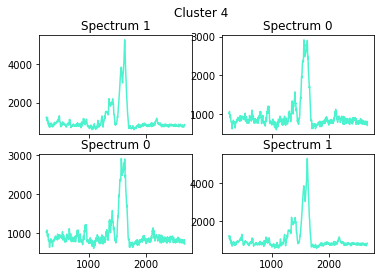

Cluster 5 has 1192 members


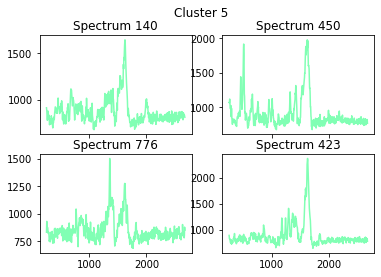

Cluster 6 has 370 members


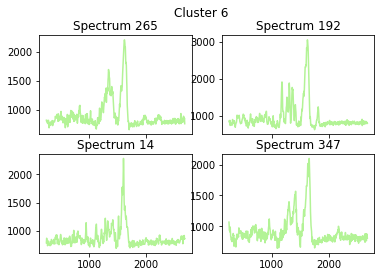

Cluster 7 has 172 members


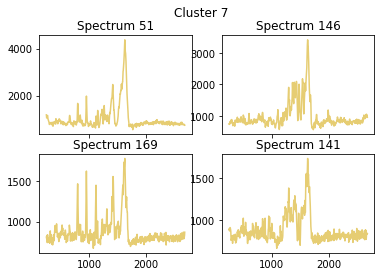

Cluster 8 has 30 members


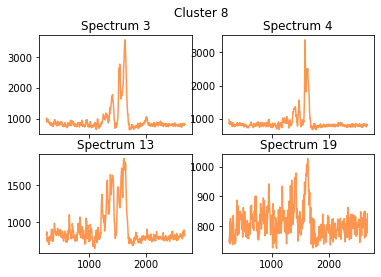

Cluster 9 has 10 members


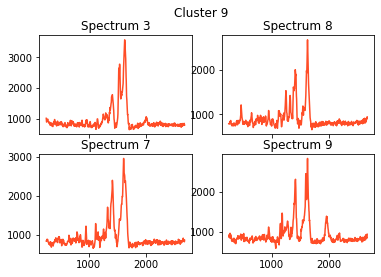

2500 spectra accounted for


In [104]:
plotResult(clusters.labels_,numberOfClusters=numberOfClusters, clusters=clusters, title= "Hierarchical Clustering")

it is not really clear how much similarities are in these clusters

In [106]:
epsilons=[0.01,0.1,0.5,0.9,1,10]
for epsilon in epsilons:
    
    dbClustering=cluster.DBSCAN(eps=epsilon)
    clusters=dbClustering.fit(flatInter)
    print('Core Samples')
    print(clusters.labels_)
    plotSpectra(spectralIndices=clusters.core_sample_indices_, howMany=len(clusters.core_sample_indices_), shiftWave=xValues,clusterIDX=0)
#     plotResult(clusters.labels_, numberOfClusters, clusters, title)
    

Core Samples
[-1 -1 -1 ... -1 -1 -1]


<Figure size 432x288 with 0 Axes>

Core Samples
[-1 -1 -1 ... -1 -1 -1]


<Figure size 432x288 with 0 Axes>

Core Samples
[-1 -1 -1 ... -1 -1 -1]


<Figure size 432x288 with 0 Axes>

Core Samples
[-1 -1 -1 ... -1 -1 -1]


<Figure size 432x288 with 0 Axes>

Core Samples
[-1 -1 -1 ... -1 -1 -1]


<Figure size 432x288 with 0 Axes>

Core Samples
[-1 -1 -1 ... -1 -1 -1]


<Figure size 432x288 with 0 Axes>

/Users/morten/anaconda3/envs/MCA/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


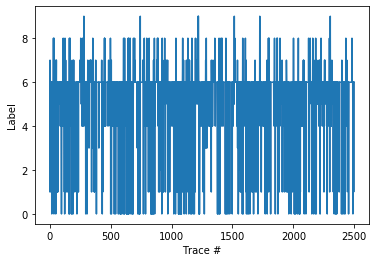

Cluster 0 has 128 members


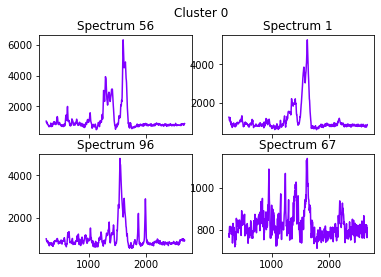

Cluster 1 has 83 members


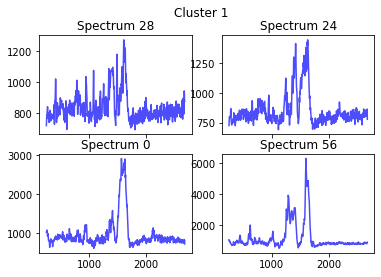

Cluster 2 has 8 members


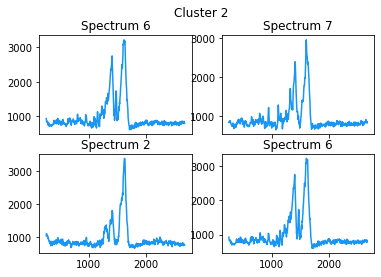

Cluster 3 has 25 members


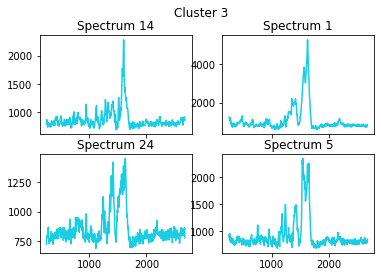

Cluster 4 has 138 members


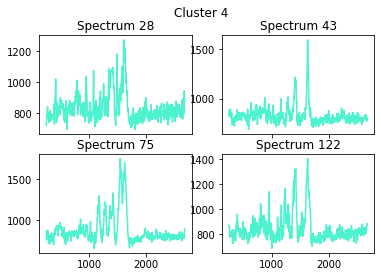

Cluster 5 has 62 members


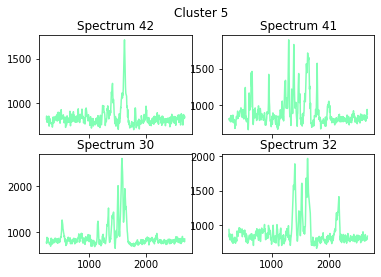

Cluster 6 has 1931 members


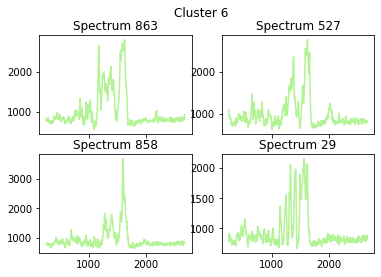

Cluster 7 has 58 members


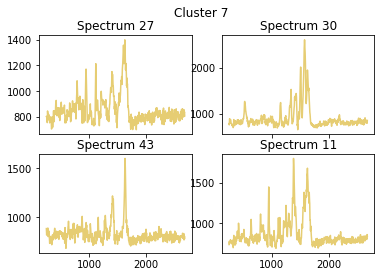

Cluster 8 has 60 members


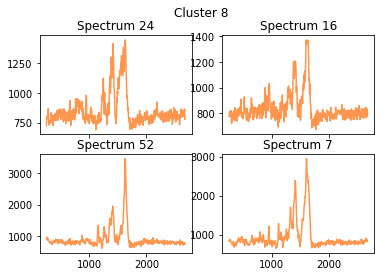

Cluster 9 has 7 members


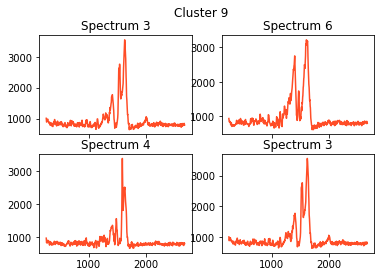

2500 spectra accounted for


/Users/morten/anaconda3/envs/MCA/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


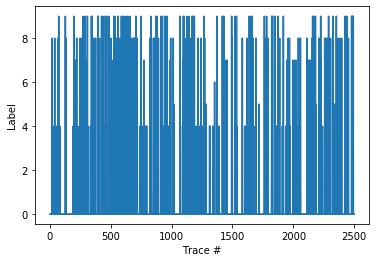

Cluster 0 has 2262 members


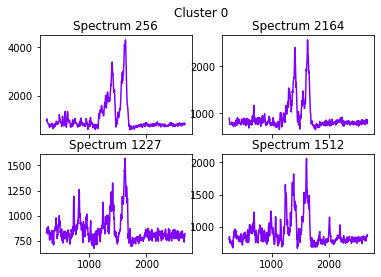

Cluster 1 has 1 members


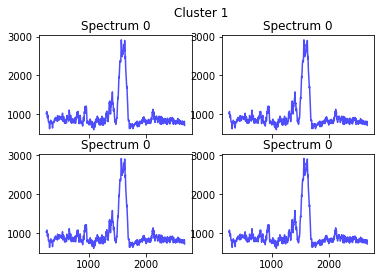

Cluster 2 has 1 members


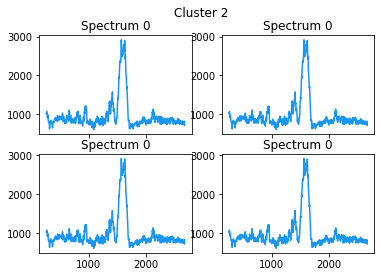

Cluster 3 has 2 members


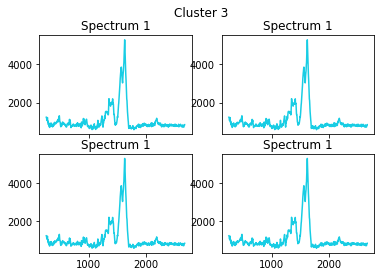

Cluster 4 has 61 members


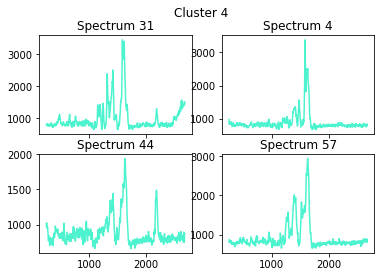

Cluster 5 has 12 members


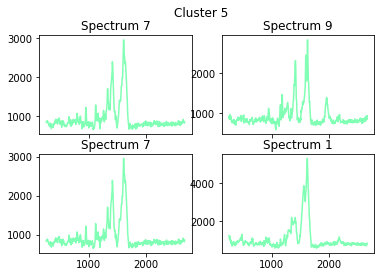

Cluster 6 has 3 members


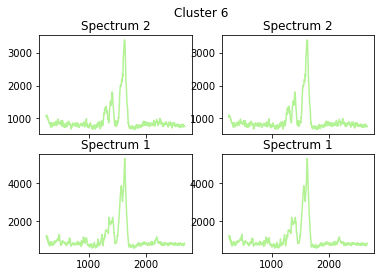

Cluster 7 has 25 members


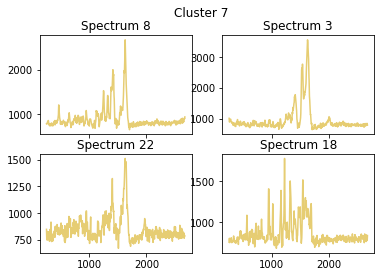

Cluster 8 has 62 members


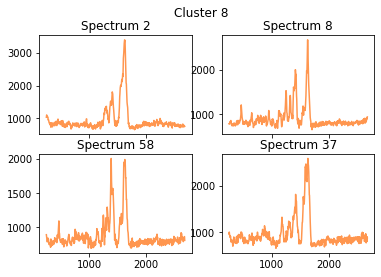

Cluster 9 has 71 members


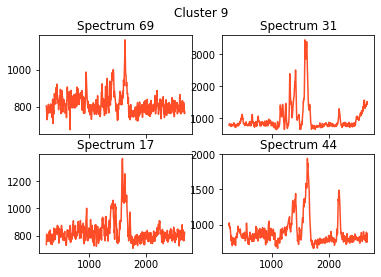

2500 spectra accounted for


/Users/morten/anaconda3/envs/MCA/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


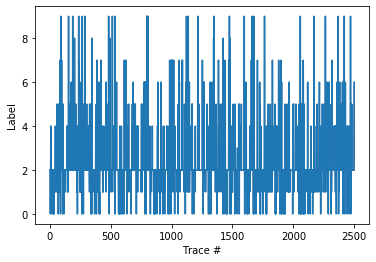

Cluster 0 has 110 members


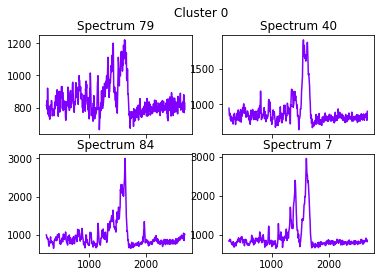

Cluster 1 has 126 members


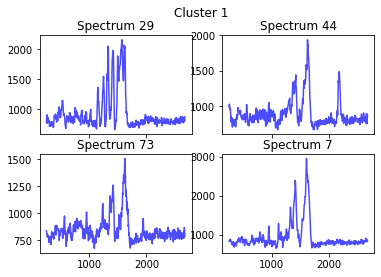

Cluster 2 has 1980 members


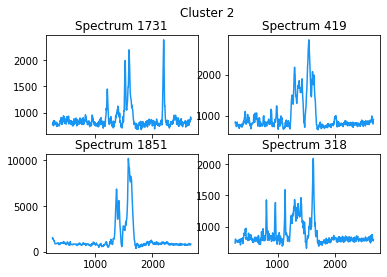

Cluster 3 has 1 members


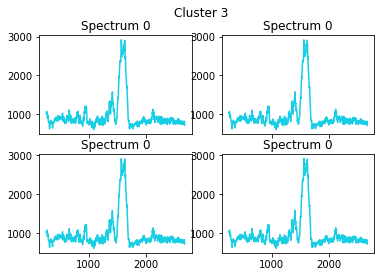

Cluster 4 has 102 members


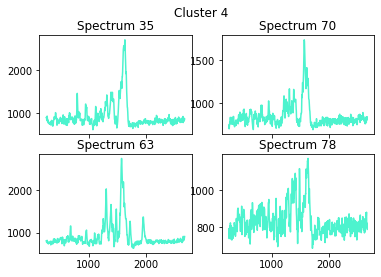

Cluster 5 has 76 members


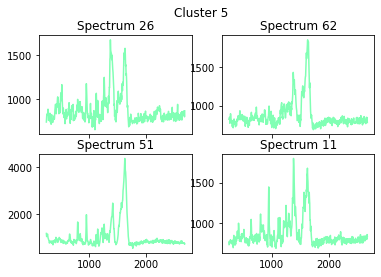

Cluster 6 has 41 members


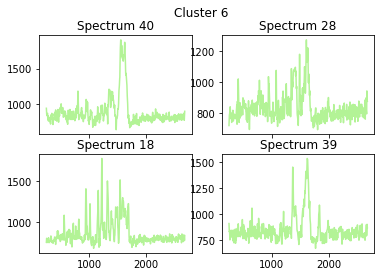

Cluster 7 has 31 members


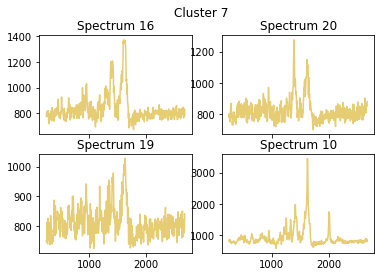

Cluster 8 has 6 members


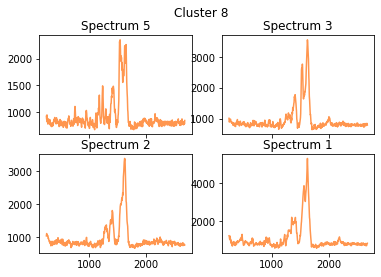

Cluster 9 has 27 members


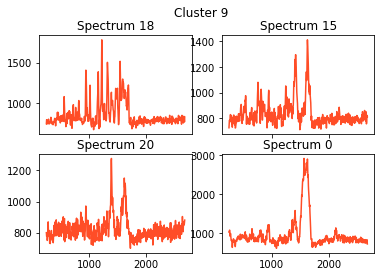

2500 spectra accounted for


/Users/morten/anaconda3/envs/MCA/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


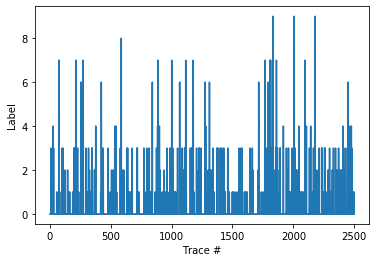

Cluster 0 has 2220 members


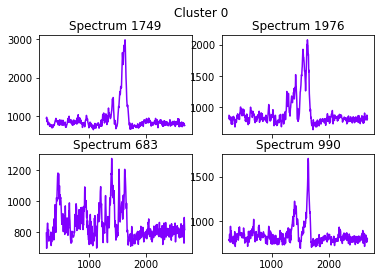

Cluster 1 has 101 members


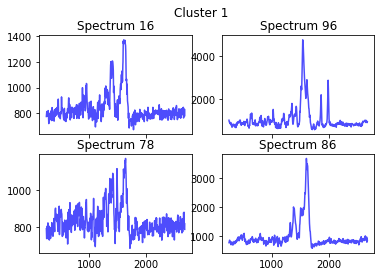

Cluster 2 has 55 members


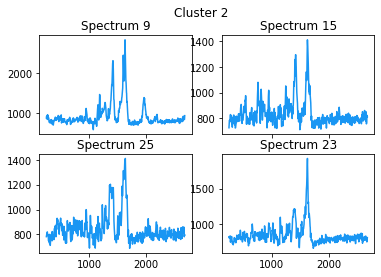

Cluster 3 has 83 members


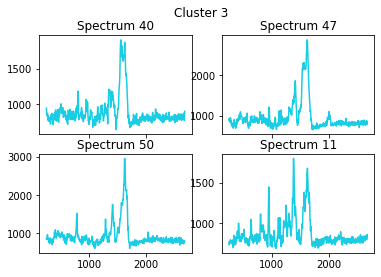

Cluster 4 has 15 members


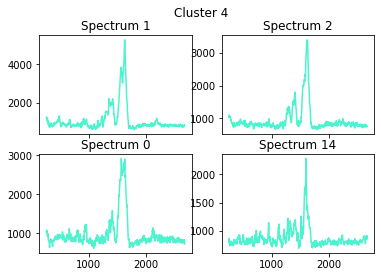

Cluster 5 has 1 members


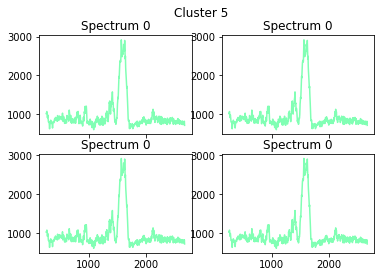

Cluster 6 has 9 members


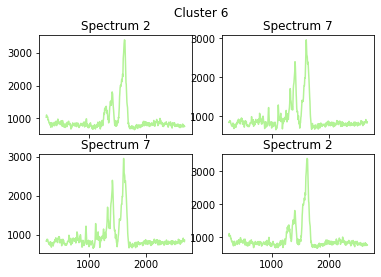

Cluster 7 has 12 members


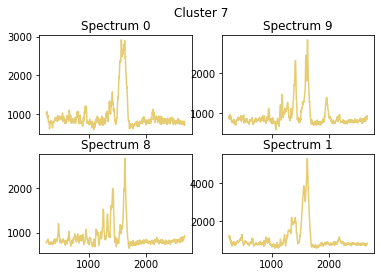

Cluster 8 has 1 members


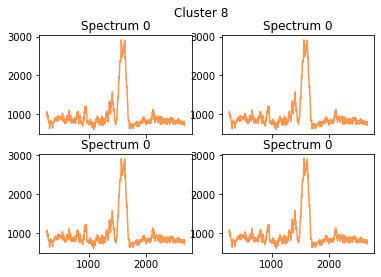

Cluster 9 has 3 members


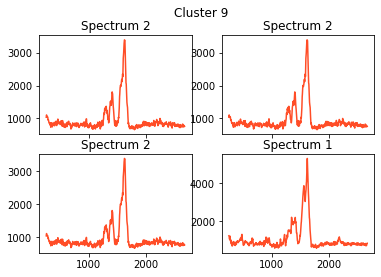

2500 spectra accounted for


/Users/morten/anaconda3/envs/MCA/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


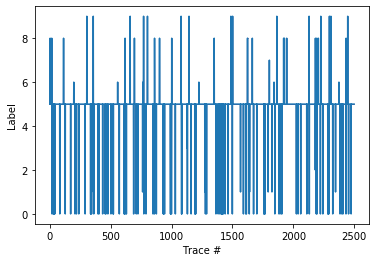

Cluster 0 has 101 members


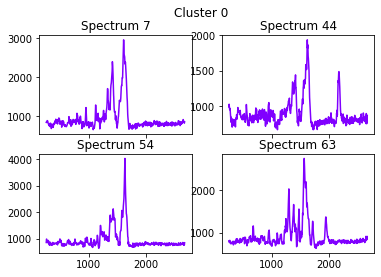

Cluster 1 has 10 members


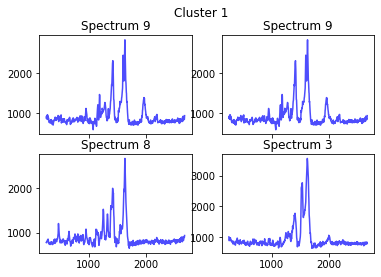

Cluster 2 has 1 members


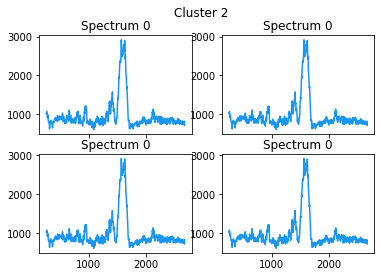

Cluster 3 has 1 members


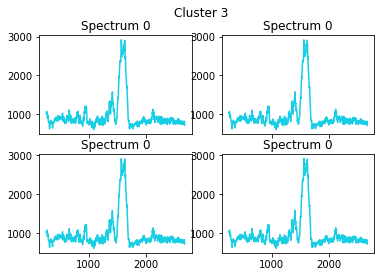

Cluster 4 has 1 members


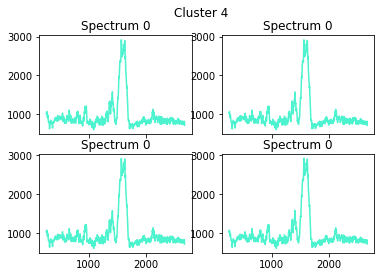

Cluster 5 has 2344 members


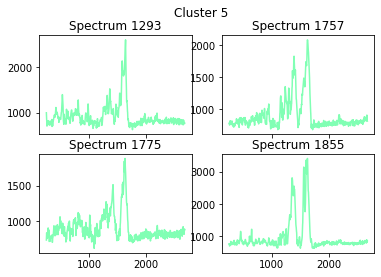

Cluster 6 has 7 members


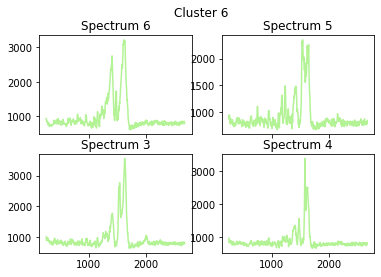

Cluster 7 has 1 members


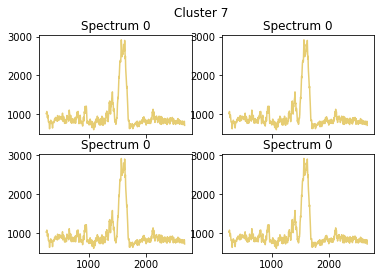

Cluster 8 has 19 members


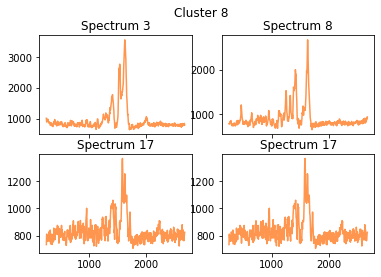

Cluster 9 has 15 members


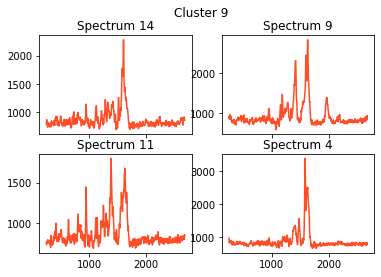

2500 spectra accounted for


/Users/morten/anaconda3/envs/MCA/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


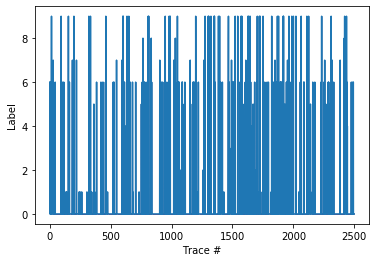

Cluster 0 has 2274 members


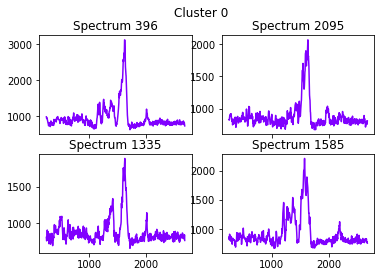

Cluster 1 has 27 members


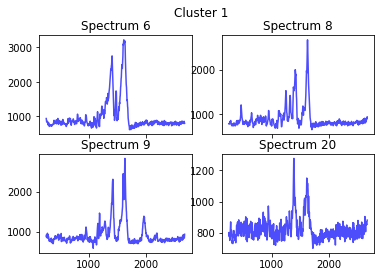

Cluster 2 has 3 members


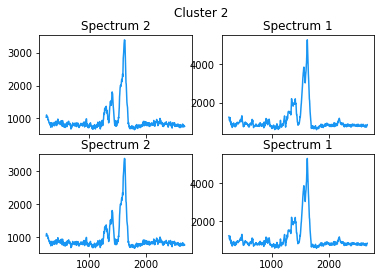

Cluster 3 has 1 members


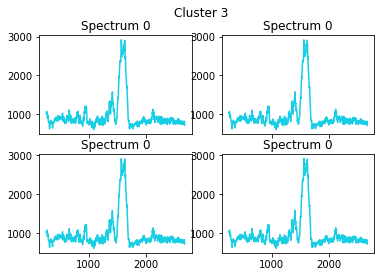

Cluster 4 has 5 members


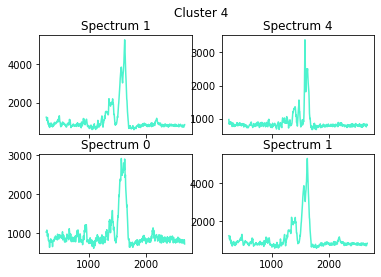

Cluster 5 has 23 members


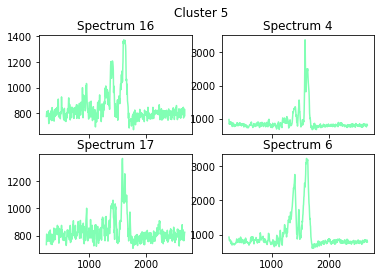

Cluster 6 has 89 members


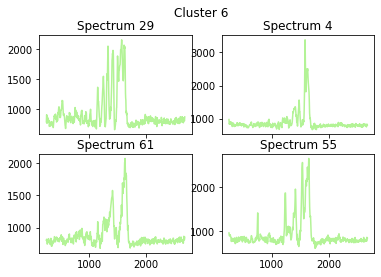

Cluster 7 has 18 members


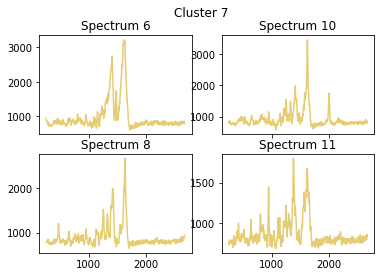

Cluster 8 has 5 members


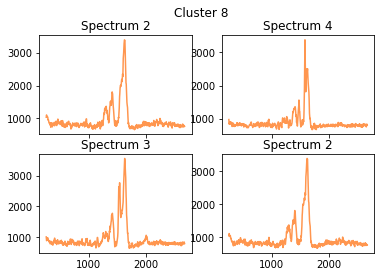

Cluster 9 has 55 members


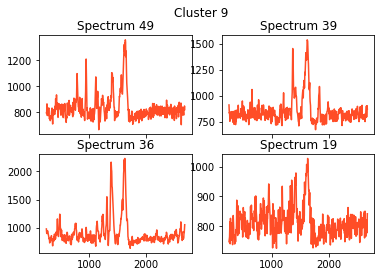

2500 spectra accounted for


In [111]:
gammas=[0.01,0.1,0.5,1,5,10]
for gamma in gammas:
    
    spClustering=cluster.SpectralClustering(n_clusters=numberOfClusters, gamma=gamma)
    clusters=spClustering.fit(flatInter)
    plotResult(clusters.labels_, numberOfClusters, clusters, "Spectral Clustering rbf={}".format(gamma), plotDendogram=False)